In [1]:
import matplotlib.pyplot as plt
from skimage import io
import torch
import os

from src.datamodules.focus_datamodule import FocusDataModule
from src.models.focus_module import FocusModule
from src.models.components.mobile_net_v3 import MobileNetV3
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.transforms.functional import InterpolationMode

In [2]:
path_to_model = "/home/maf4031/focus_model/logs/train/runs/2022-12-13_00-53-11/checkpoints/epoch_082.ckpt"
# load model checkpoint
checkpoint = torch.load(path_to_model, map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']
# remove net in keys from state_dict
state_dict = {k.replace("net.", ""): v for k, v in state_dict.items()}

In [3]:
model = MobileNetV3()
_ = model.load_state_dict(state_dict)
_ = model.eval()

In [102]:
distance = 20
path_to_img = f"/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_5/sample_34/distance{distance}.jpg"
img = io.imread(path_to_img)

In [103]:
# center crop 256x256 patch from image
img = img[256:512, 256:512]

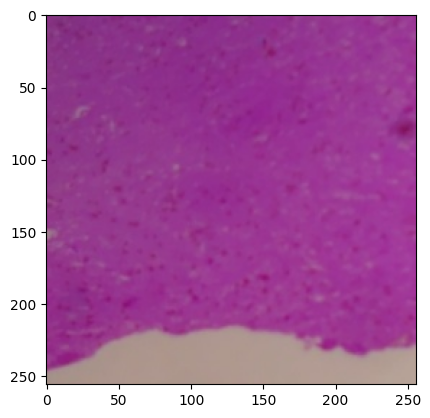

In [104]:
plt.imshow(img)
plt.show()

In [105]:
transform = transforms.Compose([
            transforms.ToTensor(), 
            #transforms.Resize(size=(h_scaled, w_scaled), interpolation=InterpolationMode.BILINEAR),
            transforms.Normalize((0), (1)),
        ])
img_torch = transform(img)
img_torch = img_torch.unsqueeze(0)

In [106]:
with torch.no_grad():
    output = model(img_torch)
print(output)
print(distance*3.4)

tensor([[79.1017]])
68.0


In [109]:
from src.datamodules.components.focus_dataset import FocusDataset
d = torch.load("/home/maf4031/focus_model/data/datasets/dataset_subsample100_grid.pt")